In [1]:
from eval_gnn import eval_gnn
from str2env import str2env
import numpy as np
import torch
from time import time
from torch_geometric.data import Data
from config import set_random_seed
from tqdm import tqdm as tqdm
from torch_sparse import coalesce
from torch_geometric.nn import knn_graph

loop = 5
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

/home/wenjin/anaconda3/envs/gnnmp/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
pybullet build time: May 20 2022 19:44:17


In [2]:
def to_np(tensor):
    return tensor.data.cpu().numpy()

In [3]:
class DotDict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

    
def obs_data(env, free, collided):
    data = DotDict({
        'free': torch.FloatTensor(np.array(free)).to(device),
        'collided': torch.FloatTensor(np.array(collided))[:len(free)].to(device),
        'obstacles': torch.FloatTensor(env.obstacles).to(device),
    })
    return data

In [4]:
# test on new environment
from config import set_random_seed
from str2name import str2name


from environment import MazeEnv
env = MazeEnv(dim=2)
indexes = range(0, 1000)
bs = 100  # only sample 100 points

env.init_new_problem(0)
set_random_seed(1234)
_, model, model_path, model_s, model_s_path = str2name(str(env))

# result = explore(env, model, model_s, smooth=True, smoother='model', batch=bs, t_max=bs, k=10)


In [5]:
def create_data(free, collided, env, k):
    data = Data(goal=torch.FloatTensor(env.goal_state))
    
    # graph vertices start point + end point + free + collied
    data.v = torch.cat((torch.FloatTensor(np.array(free)),
                        torch.FloatTensor(np.array(collided))), dim=0)

    # create labels
    data.labels = torch.zeros(len(data.v), 3)
    #  the vertices in the free space
    data.labels[:len(free), 0] = 1
    #  the vertices with collision
    data.labels[len(free):, 1] = 1
    # goal vertex
    data.labels[1, 2] = 1
    k1 = int(np.ceil(k * np.log(len(free)) / np.log(100)))
    edge_index = knn_graph(torch.FloatTensor(data.v), k=k1, loop=True)
    edge_index = torch.cat((edge_index, edge_index.flip(0)), dim=-1)
    edge_index_free = knn_graph(torch.FloatTensor(data.v[:len(free)]), k=k1, loop=True)
    edge_index = torch.cat((edge_index, edge_index_free, edge_index_free.flip(0)), dim=-1)
    data.edge_index, _ = coalesce(edge_index, None, len(data.v), len(data.v))

    return data

In [6]:
def explore(env, model, model_s, smooth=True, batch=500, t_max=1000, k=30, smoother='model', loop=5):
    '''
    model: path explore to find a possible path
    model_s: smooth model
    loop: level of gnn
    '''
    
    c0 = env.collision_check_count
    t0 = time()
    forward = 0
    
    success = False
    path, smooth_path = [], []
    n_batch = batch
    free, collided = env.sample_n_points(n_batch, need_negative=True)
    collided = collided[:len(free)]
    free = [env.init_state] + [env.goal_state] + list(free)
    
    explored = [0]
    explored_edges = [[0, 0]]
    costs = {0: 0.}
    prev = {0: 0}

    data = create_data(free, collided, env, k)
    # print(data.v.size())

    policy, log_time = model(**data.to(device).to_dict(), **obs_data(env, free, collided), loop=loop)
    return log_time


In [7]:
log_times = []
for i in tqdm(indexes):
    env.init_new_problem(i)
    set_random_seed(1234)
    _, model, model_path, model_s, model_s_path = str2name(str(env))
    log_time = explore(env, model, model_s, smooth=True, smoother=None, batch=bs, t_max=bs, k=10) 
    
    log_times.append(log_time)

100%|██████████| 1000/1000 [01:29<00:00, 11.20it/s]


In [8]:
total_time = 0
encode_time = 0
atten_time = 0
GNN_time = 0

for t in log_times:
    total_time = total_time + t["total_time"] 
    encode_time = encode_time + t["encode_time"] 
    atten_time = atten_time + t["atten_time"] 
    GNN_time = GNN_time + t["GNN_time"] 

total_time  = total_time / len(log_times)
encode_time = encode_time / len(log_times)
atten_time = atten_time / len(log_times)
GNN_time = GNN_time / len(log_times)
print("total time:{0:.2f}; encoder_time:{1:.2f};  attention time: {2:.2f}; GNN time:{3:.2f}".format(total_time*1000, encode_time*1000, atten_time*1000, GNN_time*1000))

total time:58.95; encoder_time:50.60;  attention time: 48.36; GNN time:8.35


In [15]:
print("total time:{0:.2f}; encoder_time:{1:.2f};  attention time: {2:.2f}; GNN time:{3:.2f}".format(total_time*1000, encode_time*1000/(total_time*1000),
 atten_time*1000/(total_time*1000), GNN_time*1000/(total_time*1000)))

total time:58.95; encoder_time:0.86;  attention time: 0.82; GNN time:0.14


In [9]:
'''
model: path explore to find a possible path
model_s: smooth model
loop: level of gnn
'''

batch=500
t_max=1000 
k=30
loop=5

c0 = env.collision_check_count
t0 = time()
forward = 0

success = False
path = []
n_batch = batch

print(type(n_batch))

free, collided = env.sample_n_points(n_batch, need_negative=True)
print("free 0:", free[0], "len:", len(free))
print("collided 0:", collided[0], "len", len(collided))


<class 'int'>
free 0: [0.16097267 0.86157326] len: 500
collided 0: [-0.96264712 -0.42837379] len 492


In [10]:
# collided len will same to free.
collided = collided[:len(free)]
free = [env.init_state] + [env.goal_state] + list(free)
print("free len:", len(free))
print("collided len", len(collided))

free len: 502
collided len 492


In [11]:
explored = [0]
explored_edges = [[0, 0]]
costs = {0: 0.}
prev = {0: 0}
data = create_data(free, collided, env, k)

In [12]:
# random tree
# idea is explore from end to start point
import matplotlib.pyplot as plt
import networkx as nx
G = nx.Graph()

class Node:
    def __init__(self, x = None, y = None, np_array = None, map_size = 2.0):
        if x != None and y != None:
            self.x, self.y = x, y
        
        if np_array.any():
            self.x, self.y = np_array
        
        self.map_size = map_size
        self.pos = (self.x, self.y)
    
    def __str__(self) -> str:

        w=15

        grid_x  = int((self.x + 1.0) * w / 2.0)
        grid_y  = int((self.y + 1.0) * w / 2.0)

        return ("point:({},{}); point in map:({},{})".format(
            self.x, self.y, grid_x, grid_y))
    
    def is_equal(self, object) -> bool:
        if isinstance(object, Node):
            if np.linalg.norm(np.array([self.x, self.y]) - np.array([object.x, object.y])) < 5e-2:
                return True
        return False
    
    def to_state(self):
        return np.array([self.x, self.y])

# add point into graph (vertices is the explored points. explore from goal point)
node_start = Node(np_array = env.init_state)
node_goal = None
node_start_updated = 0

# G.add_node(node_goal)
# check graph connection

In [13]:
policy = model(**data.to(device).to_dict(), **obs_data(env, free, collided), loop=loop)

In [14]:
# data.edge_index = radius_graph(data.v, radius(len(data.v)), loop=True)

while not success and (len(free) - 2) <= t_max:

    t1 = time()
    policy = model(**data.to(device).to_dict(), **obs_data(env, free, collided), loop=loop)

    # print("-------policy------")
    # print(policy.size())
    # print("-------end policy------")
    
    policy = policy.cpu()
    forward += time() - t1

    policy[torch.arange(len(data.v)), torch.arange(len(data.v))] = 0
    policy[:, explored] = 0
    policy[:, data.labels[:, 1] == 1] = 0
    policy[data.labels[:, 1] == 1, :] = 0
    policy[np.array(explored_edges).reshape(2, -1)] = 0

    success = False

    while policy[explored, :].sum() != 0:
        # print(torch.where(policy[explored, :] != 0))
        agent = policy[
            np.array(explored)[torch.where(policy[explored, :] != 0)[0]], torch.where(policy[explored, :] != 0)[
                1]].argmax()
        # print("agent", agent)
        end_a, end_b = torch.where(policy[explored, :] != 0)[0][agent], torch.where(policy[explored, :] != 0)[1][
            agent]
        # print("{} --> {}".format(end_a, end_b))
        
        end_a, end_b = int(end_a), int(end_b)
        end_a = explored[end_a]
        explored_edges.extend([[end_a, end_b], [end_b, end_a]])
        
        state_a = to_np(data.v[end_a])
        state_b = to_np(data.v[end_b])

        if env._edge_fp(state_a, state_b):
            explored.append(end_b)
            costs[end_b] = costs[end_a] + np.linalg.norm(state_a - state_b)
            prev[end_b] = end_a

            # add edge to graph
            tmp_a = Node(np_array = state_a)
            tmp_b = Node(np_array = state_b)
            G.add_edge(tmp_a, tmp_b, weight=np.linalg.norm(state_a - state_b))

            # check it is goal point
            if node_start_updated == 0 and node_start.is_equal(tmp_a):
                # update start point
                print("update start point a")
                node_start = tmp_a
                node_start_updated = node_start_updated + 1
            
            policy[:, end_b] = 0
            if env.in_goal_region(state_b):
                node_goal = tmp_b
                success = True
                cost = costs[end_b]
                path = [end_b]
                node = end_b
                
                while node != 0:
                    path.append(prev[node])
                    node = prev[node]
                path.reverse()
                break
        else:
            policy[end_a, end_b] = 0
            policy[end_b, end_a] = 0

    if not success:
        print("no success")
        if (n_batch + len(free) - 2) > t_max:
            break
        # ----------------------------------------resample----------------------------------------
        new_free, new_collided = env.sample_n_points(n_batch, need_negative=True)
        free = free + list(new_free)
        collided = collided + list(new_collided)
        collided = collided[:len(free)]
        data = create_data(free, collided, env, k)
    else:
        path = list(data.v[path].data.cpu().numpy())

c_explore = env.collision_check_count - c0


AttributeError: 'tuple' object has no attribute 'cpu'

In [ ]:
print(path)

[array([ 0.7957889, -0.7179079], dtype=float32), array([ 0.8031402 , -0.34297213], dtype=float32), array([ 7.590522e-01, -1.596716e-04], dtype=float32), array([0.8625942 , 0.34632558], dtype=float32), array([0.8116144, 0.5371665], dtype=float32), array([0.73265105, 0.7375675 ], dtype=float32), array([0.5456532, 0.7652824], dtype=float32), array([0.5798496, 0.6615492], dtype=float32), array([0.58215195, 0.5745794 ], dtype=float32), array([0.5523614, 0.564956 ], dtype=float32), array([0.57010114, 0.45341033], dtype=float32), array([0.55708086, 0.44088542], dtype=float32), array([0.5654712 , 0.40271077], dtype=float32), array([0.46803057, 0.3671358 ], dtype=float32), array([0.48107448, 0.3451935 ], dtype=float32), array([0.5043137 , 0.28052872], dtype=float32), array([0.5674444, 0.2119957], dtype=float32), array([0.42967275, 0.34067878], dtype=float32), array([0.259213, 0.567262], dtype=float32), array([0.3156415, 0.554172 ], dtype=float32), array([0.08340586, 0.5612613 ], dtype=float32),

In [ ]:
# check graph search from node_start to node_goal


<Figure size 640x480 with 0 Axes>

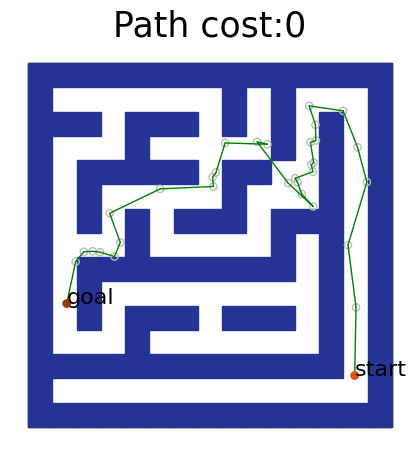

In [ ]:
from utils.plot import plot_edges, plot_env_only, plot_optimization_edges
%matplotlib inline
import matplotlib.pyplot as plt
from utils.plot import plot_edges

edges = data.v[np.array(explored_edges).reshape(-1) ].reshape(-1, 2, 2)

edges = [[tuple(k), tuple(v)] for k, v in zip(edges[:, 0, :].cpu().numpy(), edges[:, 1, :].cpu().numpy())]
# distance = env.path_distance(path)
plot_optimization_edges(path, edges, env.get_problem(), \
           title='Path cost:{}'.format(0), \
           save=None)
plt.show()

In [ ]:

nodes = list(G.nodes)
print(len(nodes))


(x, y) = list(G.edges)[0]
print(x.to_state(), y.to_state())



702
[ 0.7957889 -0.7179079] [ 0.8031402  -0.34297213]


In [ ]:
from utils.plot import draw_edge, draw_node
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_graph(G, problem, fig=None, edge_classes=None, title='Figure', title_size=25):
    print(list(G.nodes)[0])

    nodes = [x.to_state() for x in list(G.nodes)]

    edges = [(x.to_state(), y.to_state()) for (x, y) in list(G.edges)]  
    
    plt.clf()
    environment_map = problem["map"]
    init_state = problem["init_state"]
    goal_state = problem["goal_state"]
    dim = init_state.size

    if fig is None:
        fig = plt.figure(figsize=(4, 4))

    rect = patches.Rectangle((0.0, 0.0), 2.0, 2.0, linewidth=1, edgecolor='black', facecolor='none')
    plt.gca().add_patch(rect)

    map_width = environment_map.shape
    d_x = 2.0 / map_width[0]
    d_y = 2.0 / map_width[1]
    for i in range(map_width[0]):
        for j in range(map_width[1]):
            if environment_map[i, j] > 0:
                rect = patches.Rectangle((d_x * i, d_y * j), d_x, d_y, linewidth=1, edgecolor='#253494',
                                         facecolor='#253494')
                plt.gca().add_patch(rect)

    for i in range(len(nodes)):
        draw_node(nodes[i], '#bbbbbb', dim=dim)
        # plt.annotate('{}'.format(i), states[i]+1.0, color='black', fontsize=20)

    for i in range(len(edges)):
        draw_edge(edges[i][0], edges[i][1], 'green', dim=dim)
        

    draw_node(init_state, '#e6550d', dim=dim, face=True)
    draw_node(goal_state, '#a63603', dim=dim, face=True)
    
    plt.annotate('start', init_state+1.0, color='black', fontsize=16)
    plt.annotate('goal', goal_state+1.0, color='black', fontsize=16)

    plt.axis([0.0, 2.0, 0.0, 2.0])
    plt.axis('off')
    plt.axis('square')

    plt.subplots_adjust(left=-0., right=1.0, top=1.0, bottom=-0.)

    if title == '':
        plt.title('#%d Samples' % len(states) + ' #%d Edges' % len(edges), fontdict = {'fontsize':title_size})
    else:
        plt.title(title, fontdict = {'fontsize':title_size})

    # plt.show()

    return fig

point:(0.7957888841629028,-0.7179079055786133); point in map:(13,2)


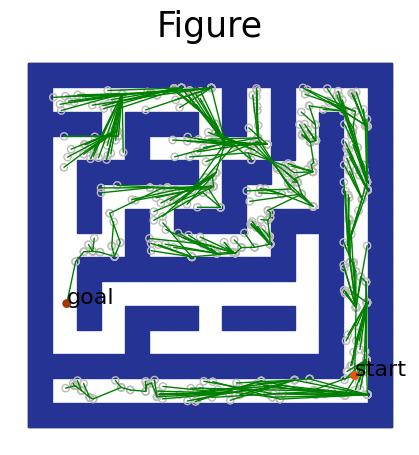

<Figure size 640x480 with 0 Axes>

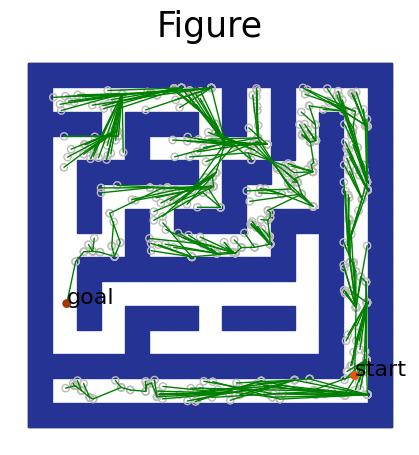

In [ ]:
plot_graph(G, env.get_problem())

In [ ]:
for node in G.nodes:
    G.nodes[node]['pos'] = node.pos


True
True


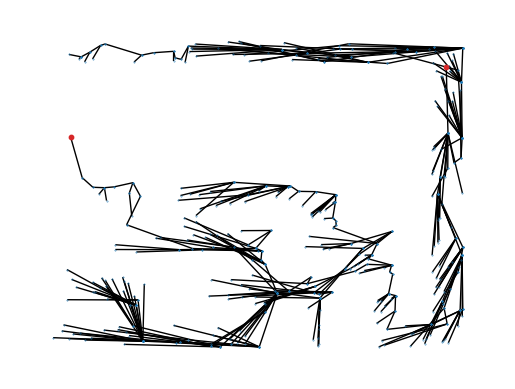

In [ ]:
from matplotlib import pyplot
pyplot.gca().invert_yaxis()

nx.draw(G, nx.get_node_attributes(G, 'pos'), node_size=0.1)
print(G.has_node(node_start))
print(G.has_node(node_goal))
nx.draw_networkx_nodes(G, nx.get_node_attributes(G, 'pos'), nodelist=[node_start, node_goal], node_color="tab:red", node_size=10)

In [ ]:
print(nx.shortest_path(G, source=node_start, target=node_goal, weight="weight"))

NetworkXNoPath: No path between point:(0.7957888841629028,-0.7179079055786133); point in map:(13,2) and point:(-0.7879956364631653,-0.32205504179000854); point in map:(1,5).

In [ ]:
from copy import deepcopy
graph = deepcopy(G)

number_nodes = len(graph.nodes)
nodes = list(graph.nodes)
count = 0
for i in range(number_nodes):
    for j in range(i+1, number_nodes):
        node_x, node_y = nodes[i], nodes[j]
        if not graph.has_edge(node_x, node_y):
            if env._edge_fp(node_x.to_state(), node_y.to_state()):
                graph.add_edge(node_x, node_y, weight=np.linalg.norm(node_x.to_state() - node_y.to_state()))
                count = count + 1
            else:
                break
print("add {} edges".format(count))

add 4157 edges


In [ ]:
print(len(graph.nodes))
print(len(G.nodes))

702
702


point:(0.7957888841629028,-0.7179079055786133); point in map:(20,9)


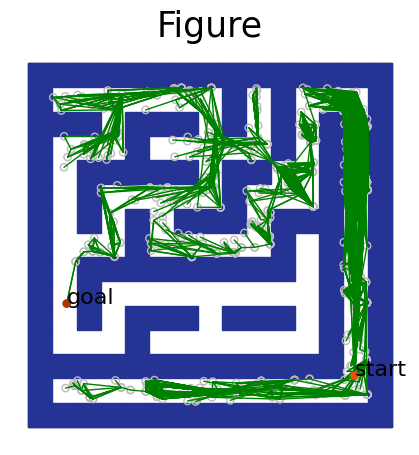

<Figure size 640x480 with 0 Axes>

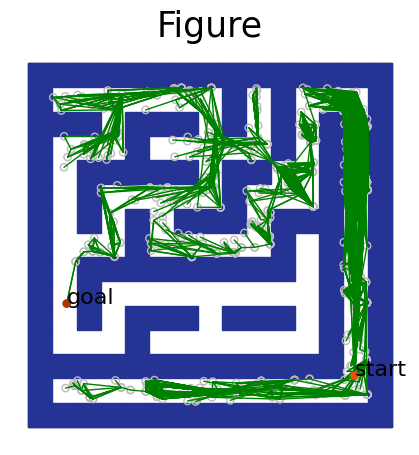

In [ ]:
plot_graph(graph, env.get_problem())

In [ ]:
print(graph.edges(node_start))
print(graph.edges(node_goal))

NetworkXError: nbunch is not a node or a sequence of nodes.

In [ ]:
print(nx.shortest_path(graph, source=node_start, target=node_goal, weight="weight"))

NetworkXNoPath: No path between point:(0.7957888841629028,-0.7179079055786133); point in map:(20,9) and point:(-0.7879956364631653,-0.32205504179000854); point in map:(9,12).